# Creating a Siamese neural network in Keras

We are finally ready to start creating a Siamease neural network in Keras.

The following diagram shows the detailed architecture of the Siamese neural network we'll build:

![diagram](https://i.imgur.com/9OWIu07.png)

Let's start by creating the shared convolutional network in Keras

In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
CURRENT_DIR = Path('.').resolve()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
CURRENT_DIR.parent.joinpath('content','drive','MyDrive','Data','Facial-Recognition','src').exists()

True

In [6]:
MODULES_DIR = CURRENT_DIR.parent.joinpath('content','drive','MyDrive','Data','Facial-Recognition','src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.parent.joinpath('content','drive','MyDrive','Data','Facial-Recognition','Data')

face_dir = DATA_DIR.joinpath('att_faces')

from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
import data_load_and_split
X_test, Y_test, X_train, Y_train = data_load_and_split.load_and_split(face_dir)

Let'sdefine a function that builds this shared convolutional network using network using the `Sequential` class in Keras

In [7]:
import model_creation
from keras.layers import Input

We can see that this function creates a convolutional network according to the architecture in the preceding diagram. How do we actually share weights across two network in Keras? Well, the short answer is that we don't actually need to create two different networks. We only need a single instance of the shared network to be declared in Keras. We can create the top and bottom convolutional network using this single instance. Because we are reusing this single instance, Keras will automatically understand that the weights are to be shared.

First, let's create a single instance of the shared network, using the function

In [8]:
input_shape = X_train.shape[1:]

shared_network = model_creation.create_shared_network(input_shape)

We specify the input for the top and bottom layers using the `input` class

In [9]:
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

Next, we stack the shared network to the right of the input layers, using the `functional` method in Keras. The syntax to do this is as follows

In [10]:
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)

Therefore, we use the `functional` method for building such a model. At this point, this is what our model looks like

![diagram_1](https://i.imgur.com/ZVTZFrc.png)

All that's left is to combine the output from the top and bottom, and to measure the Euclidean distance between the two outputs.

Since there is no a layer in Keras that can readily compute the Euclidean distance between two arrays, we would have to define our own later. The `Lambda` layer in Keras allows us to do exactly that by wrapping an arbitrary function as a `Layer` object

Let's create a euclidean_distance function

We can then wrap this `euclidean_distance` function inside a `Lambda` layer

In [11]:
from keras.layers import Lambda

distance = Lambda(model_creation.euclidean_distance, output_shape=(1,))([output_top,output_bottom])

We combine the distance layer defined in the proviuos line with out inputs to complete our model


In [12]:
from keras.models import Model

model = Model(
    inputs=[input_top,input_bottom], outputs=distance)

We can verify the structure of our model

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 92, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 112, 92, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Shared_Conv_Network (Sequentia  (None, 128)         18707264    ['input_1[0][0]',                
 l)                                                               'input_2[0][0]']            

-----

# Model Training in Keras

Now that we have created our Siamese neural network, we can start to train our model.

The following diagram illustrates the differences between training a CNN and Siamese neural network

![diagram illustrates](https://i.imgur.com/OqdtNl2.png)

We need to write a function that creates these pairs of arrays of images from X_train and Y_train. An important point we need to note is that in the pair of arrays of images, the number of classes should be equal, and that we should alternate between positive and negative pairs. This prevents our model from being biased, and ensures that it learns both positive and negative pairs of images equally well.

In [14]:
training_pairs, training_labels = model_creation.create_pairs(X_train, Y_train, 0,35)

In [15]:
test_pairs, test_labels = model_creation.create_pairs(X_test, Y_test, 35,40)

We define the following function for calculating the contrastive loss.

Alright, we have all the necessary functions to train our Siamese neural network. As usual, we define the parameters of the training using the`compile` function

In [16]:
model.compile(loss = model_creation.contrastive_loss,
              optimizer='adam',
              metrics = [model_creation.accuracy])

And we train our model for 10 epochs by calling the fit function

In [17]:
model.fit(
    [training_pairs[:, 0], training_pairs[:, 1]],
    training_labels,
    batch_size=128,
    epochs=10)

Epoch 1/10
6/6 [==============================] - 13s 192ms/step - loss: 0.2501 - accuracy: 0.7747
Epoch 2/10
6/6 [==============================] - 0s 79ms/step - loss: 0.0976 - accuracy: 0.9329
Epoch 3/10
6/6 [==============================] - 1s 92ms/step - loss: 0.0545 - accuracy: 0.9816
Epoch 4/10
6/6 [==============================] - 1s 90ms/step - loss: 0.0345 - accuracy: 0.9918
Epoch 5/10
6/6 [==============================] - 1s 88ms/step - loss: 0.0250 - accuracy: 0.9987
Epoch 6/10
6/6 [==============================] - 1s 83ms/step - loss: 0.0211 - accuracy: 0.9987
Epoch 7/10
6/6 [==============================] - 1s 85ms/step - loss: 0.0155 - accuracy: 0.9959
Epoch 8/10
6/6 [==============================] - 1s 83ms/step - loss: 0.0139 - accuracy: 1.0000
Epoch 9/10
6/6 [==============================] - 1s 85ms/step - loss: 0.0133 - accuracy: 1.0000
Epoch 10/10
6/6 [==============================] - 1s 84ms/step - loss: 0.0100 - accuracy: 1.0000


-----

# Save the model

In [18]:
model.save(CURRENT_DIR.parent.joinpath('content','drive','MyDrive','Data','Facial-Recognition','models','siamese_nn2.h5'))

-----

# Analyzing the results

In [19]:
import matplotlib.pyplot as plt

1/1 [==============================] - 1s 877ms/step


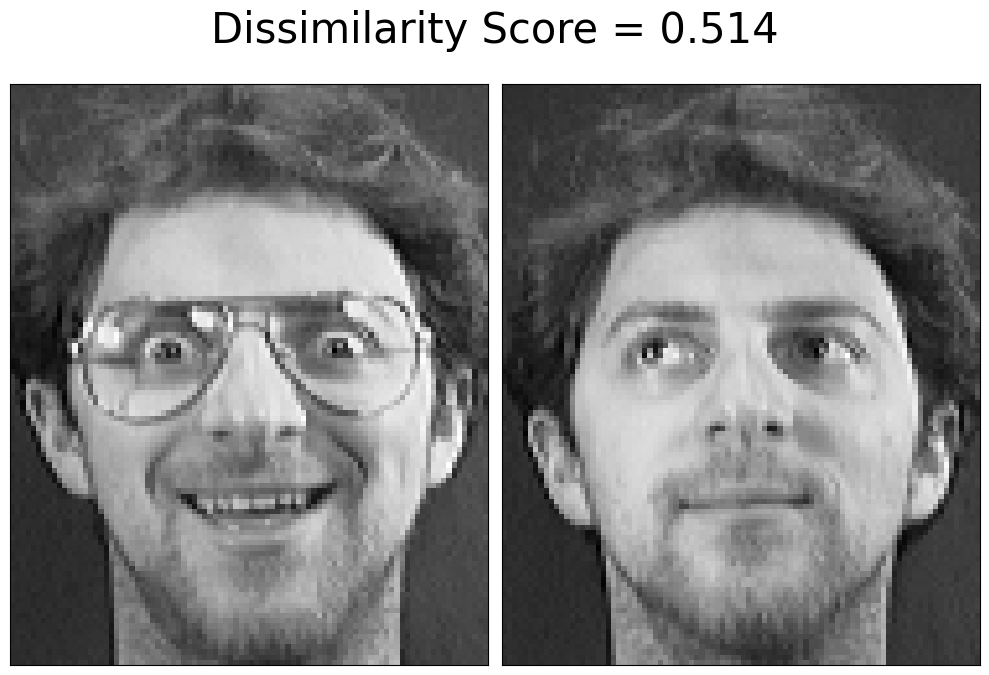

In [20]:
idx1, idx2 = 21, 29
img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), size=30)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 31ms/step


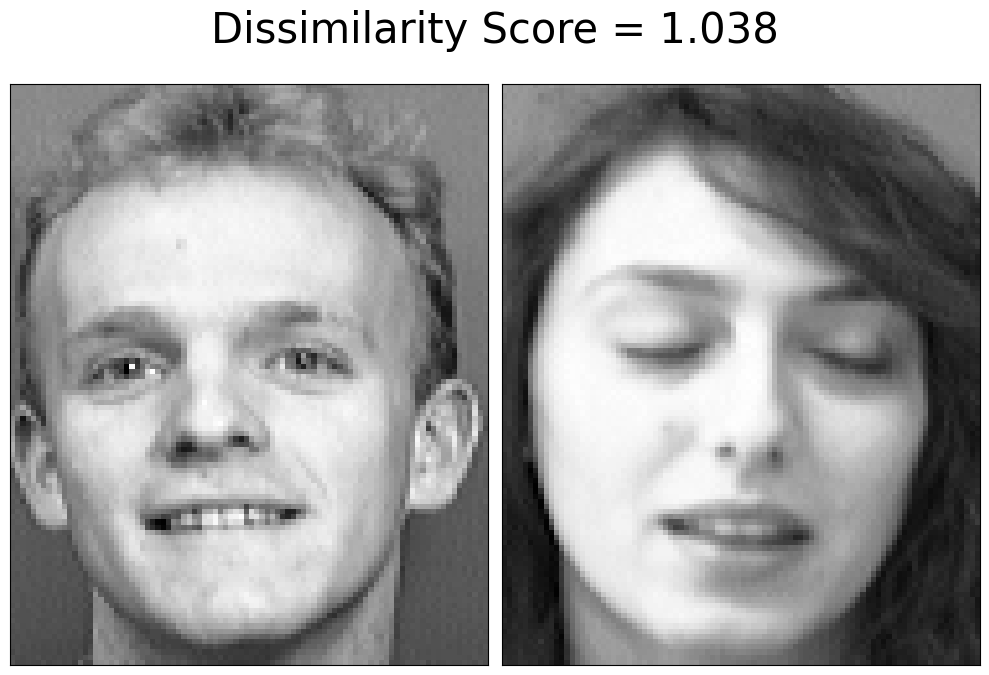

In [21]:
idx1, idx2 = 1, 37
img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), size=30)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 55ms/step


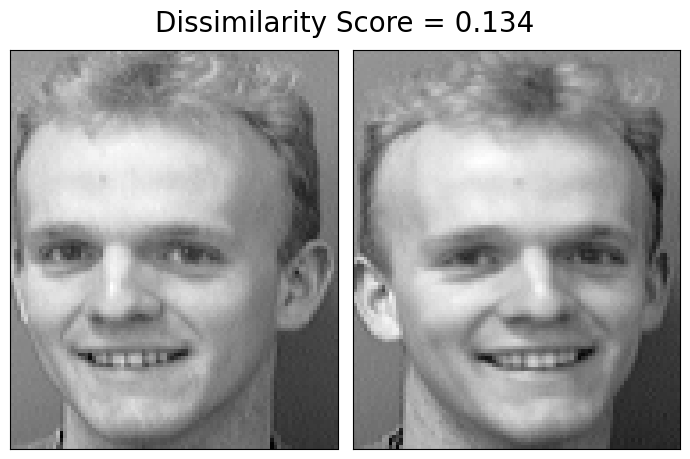

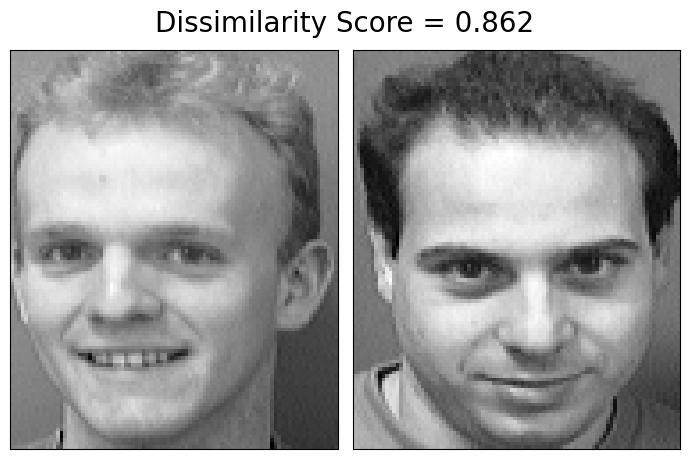

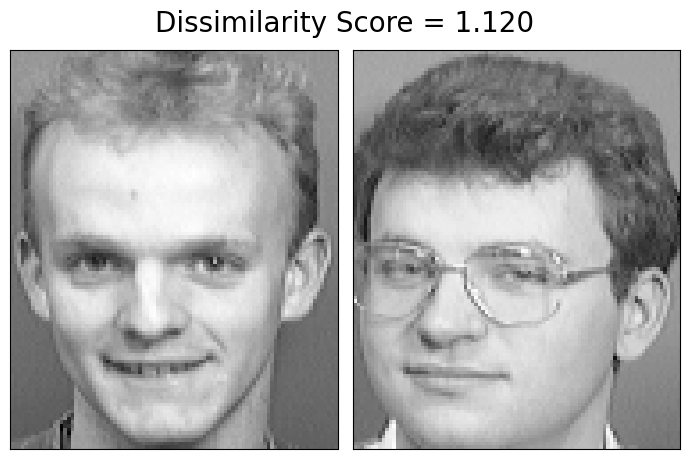

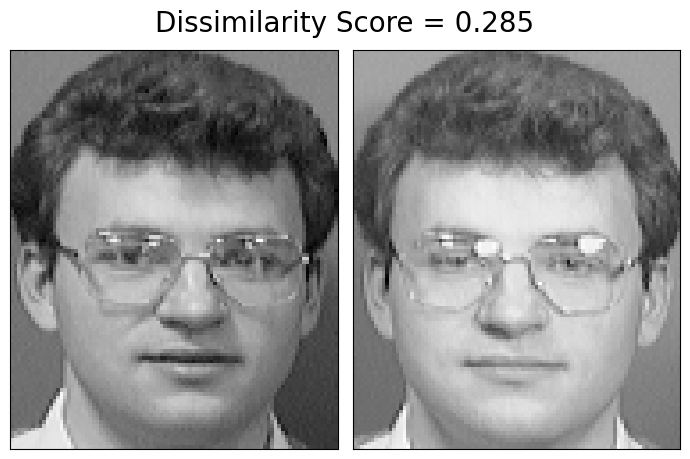

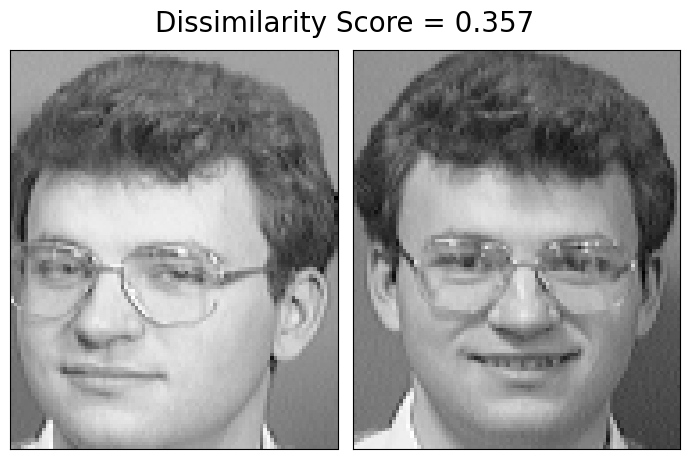

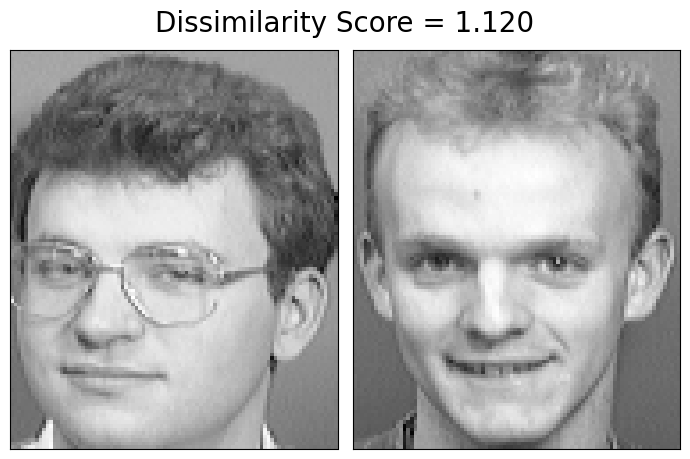

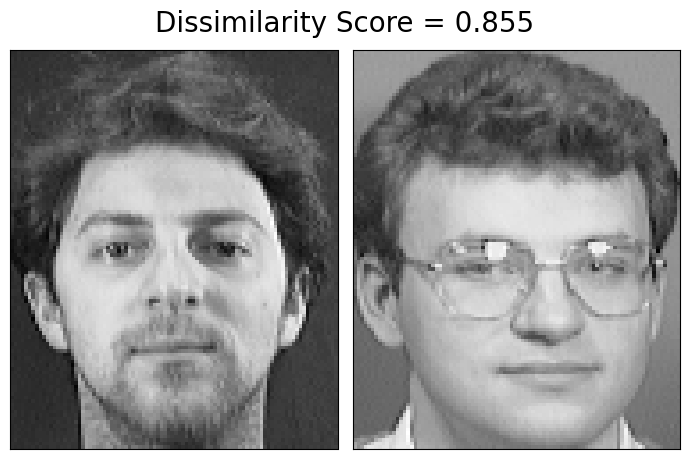

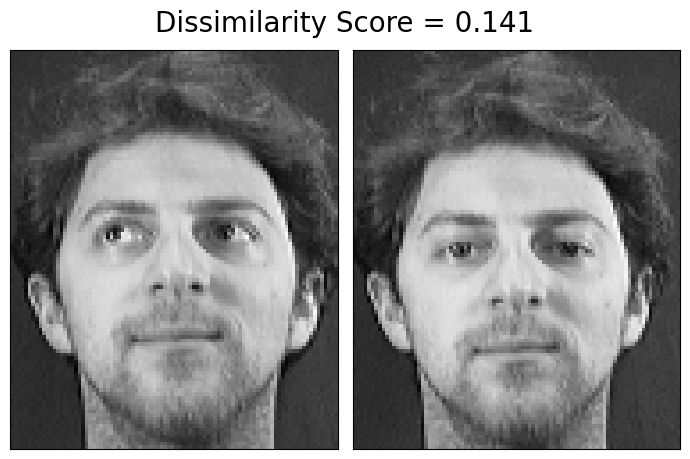

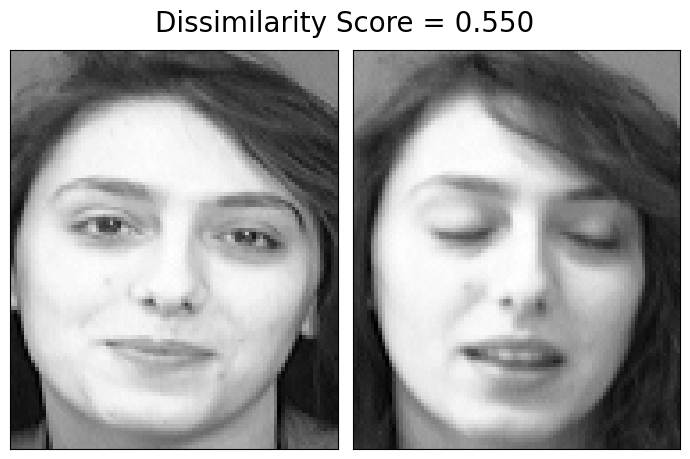

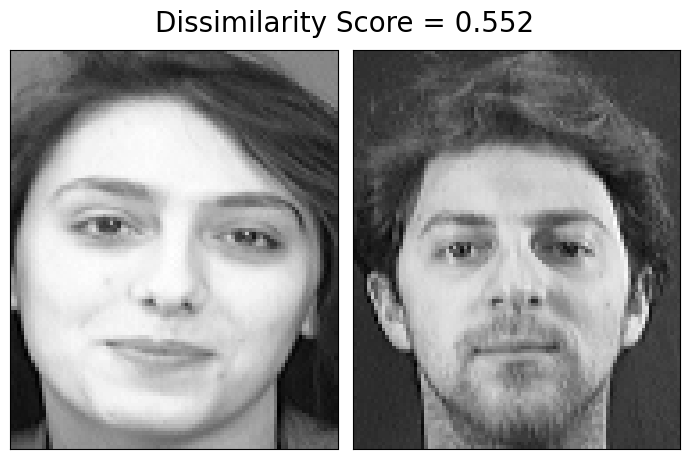

In [22]:
for i in range(5):
    for n in range(0,2):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,5))
        img1 = np.expand_dims(test_pairs[i*19+n, 0], axis=0)
        img2 = np.expand_dims(test_pairs[i*19+n, 1], axis=0)
        dissimilarity = model.predict([img1, img2])[0][0]
        img1, img2 = np.squeeze(img1), np.squeeze(img2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')

        for ax in [ax1, ax2]:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity),size=20)
plt.show()